# Spotify Data Analysis

### What is the purpose of the analysis?

I like to make music. I'm not great at it, but it's something that I really enjoy.<br>
I decided at if I am ever going to make a song that other people want to listen to, I need to look into what makes a popular song.

I found this dataset that lists song characteristics along with their popularity. This is perfect for what I'm trying to do. Let's dig into the data and see what we can find out!

In [1]:
# Some initial settings for the notebook
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('dataset.csv', index_col='Unnamed: 0')
print(df.isna().sum().sum(), 'Null values')
print(df.shape)
df.head()

3 Null values
(114000, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


114,000 songs, and 20 data points for each one and only 3 null values, not bad. Some of these such as 'duration_ms' and 'explicit' are self explanatory. Others though, like 'speechiness' and 'valence' maybe not so much.<br>
Looking at the Spotify API, I found descriptions of what these terms tell us.<br>

<img src='valence.png' width='697' height='163'>

While I have no way of testing my own music to see how Spotify would score them on these metrics, these at least give us a good indication how they are being scored.

### Seeing What is Popular

Let's start by checking the average popularity rating by genre. We'll also go ahead and get rid of those null values from before.

In [3]:
df.dropna(inplace=True)
print(df['popularity'].groupby(df['track_genre']).mean().sort_values(ascending=False))

track_genre
pop-film          59.283000
k-pop             56.952953
chill             53.651000
sad               52.379000
grunge            49.594000
                    ...    
chicago-house     12.339000
detroit-techno    11.174000
latin              8.297000
romance            3.245000
iranian            2.210000
Name: popularity, Length: 114, dtype: float64


The most popular genres are unsuprisingly both pop, and fortunately I won't have to worry about accidentally making and Iranian or Detroit-Techno music.

Let's look at how track length correlates with popularity

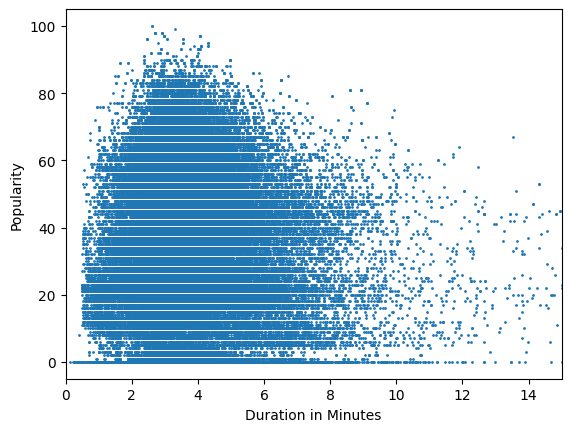

In [4]:
import matplotlib.pyplot as plt

#Convert the milliseconds into minutes
df['duration_ms'] = df['duration_ms'] / 60000

#Show the plot
df.plot(kind='scatter', x='duration_ms', y='popularity', xlim=(0,15), xlabel='Duration in Minutes', ylabel='Popularity', s=1)
plt.show()


Looks like all of the most popular songs are around 3.5 minutes long.<br>
Averageing the length of the 1000 most popular songs confirms this

In [5]:
df.sort_values('popularity', ascending=False)[0:1000].mean(numeric_only=True)[1]

3.529348483333333

Similarly we can find the average for all of the other features

In [6]:
df.sort_values('popularity', ascending=False)[0:1000].mean(numeric_only=True)

popularity           84.402000
duration_ms           3.529348
explicit              0.257000
danceability          0.654788
energy                0.679371
key                   5.399000
loudness             -6.151645
mode                  0.590000
speechiness           0.083031
acousticness          0.189284
instrumentalness      0.026936
liveness              0.168595
valence               0.507603
tempo               118.351470
time_signature        3.943000
dtype: float64

Now lets see these stats for only the type of music that I'm interested in making.

In [14]:
df[df['track_genre'].str.contains('rock|metal')].sort_values('popularity', ascending=False)[0:1000].mean(numeric_only=True)

popularity           74.923000
duration_ms           4.052181
explicit              0.113000
danceability          0.506352
energy                0.744214
key                   5.153000
loudness             -6.647100
mode                  0.674000
speechiness           0.059214
acousticness          0.123134
instrumentalness      0.046439
liveness              0.184351
valence               0.495480
tempo               123.503214
time_signature        3.941000
dtype: float64

## Modeling the relationship between the variables and popularity

Machine learning is not my biggest strong suit, but I had a few ideas on how to incorporate some learning and experimentation into this project.

### Step 1: Selecting the features

Since the degree of correlation and type of correlation between the different features and the popularity varies, We're going to calculate the Spearman correlation for each feature, since it is robust at finding different types of correlations.

In [15]:
from scipy.stats import spearmanr

# Select the columns to test
cols = ['popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']

# Compute the Spearman's Rank Correlation between each column and the popularity
for col in cols:
    corr, _ = spearmanr(df[col], df['popularity'])
    print(f"{col}:{corr:.3f}")

popularity:1.000
duration_ms:0.028
explicit:0.040
danceability:0.027
energy:-0.024
key:-0.003
mode:-0.015
speechiness:-0.068
acousticness:0.008
instrumentalness:-0.078
liveness:-0.008
valence:-0.042
tempo:0.017


Above you can see the rating for each feature. Now we'll narrow down the dataset to just the features with significant correlation.<br>
We'll also select only the 1,000 most popular songs in order to save some computing time.

In [16]:
df_filtered = df[['popularity',
       'duration_ms', 'explicit', 'danceability', 'energy',
       'mode', 'speechiness', 'instrumentalness',
       'valence', 'tempo']].nlargest(1000, 'popularity')

### Step 2: Adjust the data to work better for machine learning

Convert the explicit column from booleans to integers.

In [17]:
df_filtered['explicit'] = df_filtered['explicit'].apply(lambda x: int(x))

Now we need to scale our data to all work well together and split it into a training set and a test set.

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Define our X variable
X=df_filtered[[
       'duration_ms', 'explicit', 'danceability', 'energy',
       'mode', 'speechiness', 'instrumentalness',
       'valence', 'tempo']]

# Scale the data to range from 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X)

# Define y
y = df_filtered['popularity']

# Split the data into training and test subsets 
X_train, X_test, y_train, y_test = train_test_split(rescaledX, y, random_state=7, test_size=.2)

### Step 3: Creating the model

After some testing I determined that a Random Forest Regression model would work the best for this dataset

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5984719092669954

With no parameter tuning we get an initial r-squared value of .58<br>
In other terms, our model is 58% accurate at predicting popularity.<br>
Not too bad for default settings

Now we can use cross-validation to tune the parameters for the model.<br>
Below is the setup to test the model with a random selection of parameters to find the optimal settings.

In [20]:
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 150, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [5, 21, 37, 53, 69, 85, 101, 117, 133, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Apply the random grid to a RandomizedSearchCV object

In [21]:
# from sklearn.model_selection import RandomizedSearchCV

# rf_random = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, n_iter=50, cv=5, verbose=2, random_state=4, n_jobs=-1)

# rf_random.fit(X_train, y_train)

Now we can see what the best parameters for the model are

In [22]:
# rf_random.best_params_

Test the model with new parameters

In [23]:
rf_refined = RandomForestRegressor(n_estimators=117, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=70, bootstrap=False, random_state=4)
rf_refined.fit(X_train, y_train)
rf_refined.score(X_test, y_test)

0.7009085799135121

With the newly chosen parameters the model has an r-squared score of over 70!<br>
Now I'm going to save a serialized version of the model so that way it can just be loaded in.<br>
I'll include the Sklearn version number in the filename for future reference.

In [24]:
# import pickle
# import sklearn

# with open(f'spotify_model_sklearn_ver_{sklearn.__version__}', 'wb') as f:
#     pickle.dump(rf_refined, f)

## The Hard Part: Reverse Engineering the Spotify Song Features Algorithm

This part is really stretching my knowledge of these methodologies, but here is what I'm thinking.<br>
Get an audio file for each of the 1000 songs used to train the previous model.<br>
Convert the audio files into spectrogram images.<br>
Feed the images into TensorFlow and associate them with the existing values. <br>
Use the created model to get features for my own music.

### Step 1: Getting the files

I'm going to use the pytube library to download the songs from youtube.<br>
I tried to use the Spotify API, but you can only access 30s segments of the songs.

In [33]:
# I'm only going to use the top 100 songs, but there are some duplicates amongst the top songs so we'll grab 250 to start.
df_files = df.nlargest(250, 'popularity')
df_files.drop_duplicates(subset='track_id', keep='first', inplace=True)

# Actually get 100
df_files = df_files.nlargest(100, 'popularity')

# Clean up the index
df_files.reset_index(inplace=True)
df_files.drop('index', axis=1, inplace=True)

In [40]:
# Create a list of songs with their artist names to search on youtube
search_queries = [f"{df_files.loc[i,'track_name']} {df_files.loc[i,'artists']}" for i in range(len(df_files))]

# Make a dictionary with the index value of each song as the key
search_queries_dict = dict(zip(range(len(df_files)), search_queries))

In [3]:
from pytube import Search
from pytube import YouTube

I ran into a bug with the pytube library originally here. The addition of youtube shorts messed with the way that the library handles download streams.<br>
The bug made it to where about half of the songs would fail to download.<br>
I found a fork of the library on github that claimed to fix the issue, but I was still getting the error. I ended up spending a bunch of time trying to find a workaround, but in the end, the fork actually did fix the issue, it just still showed the error.

In [47]:
# Loop through each item in the dictionary, search youtube, and download the song
for index, query in search_queries_dict.items():
    search = Search(query)
    search.results[0].streams.filter(only_audio=True)[0].download(filename=f'{index}.mp3', output_path='downloaded_songs')

Unexpected renderer encountered.
Renderer name: dict_keys(['reelShelfRenderer'])
Search term: Unholy (feat. Kim Petras) Sam Smith;Kim Petras
Please open an issue at https://github.com/pytube/pytube/issues and provide this log output.
Unexpected renderer encountered.
Renderer name: dict_keys(['reelShelfRenderer'])
Search term: I'm Good (Blue) David Guetta;Bebe Rexha
Please open an issue at https://github.com/pytube/pytube/issues and provide this log output.
Unexpected renderer encountered.
Renderer name: dict_keys(['reelShelfRenderer'])
Search term: La Bachata Manuel Turizo
Please open an issue at https://github.com/pytube/pytube/issues and provide this log output.
Unexpected renderer encountered.
Renderer name: dict_keys(['reelShelfRenderer'])
Search term: Me Porto Bonito Bad Bunny;Chencho Corleone
Please open an issue at https://github.com/pytube/pytube/issues and provide this log output.
Unexpected renderer encountered.
Renderer name: dict_keys(['reelShelfRenderer'])
Search term: Tit

An actual issue that I had to circumvent was the fact that the songs downloaded as .mp4 files, even though i specified to download audio only. The files were only audio, but the filetype would not work with any python audio libraries. I wrote a script that changed the file names to end in .mp3, and they opened and work with VLC, but the soundfile library could still not load them.<br>
I used an external tool to convert the mp3 files... into mp3 files. This fixed the issue, which ended up being related to the codec.<br>
<img src='Screenshot 2023-02-03 113642.png'>

### Step 2: Prepare data for model

Now I need to prepare the data by converting each song into an array and making a separate array with all of the target variables.

First though, we can look at a visual representation of the songs.<br>
Just because spectrograms are cool.

In [ ]:
import soundfile as sf
import tensorflow as tf

def mp3_to_spectrogram(filepath):
    # Load the audio file using soundfile library
    audio, sr = sf.read(filepath)

    # Convert audio to spectrogram
    stft = tf.signal.stft(audio, frame_length=1024, frame_step=512)
    spectrogram = tf.abs(stft)

    # Normalize the spectrogram
    spectrogram = tf.math.log(spectrogram + 1e-10)
    spectrogram = (spectrogram - tf.math.reduce_min(spectrogram)) / (tf.math.reduce_max(spectrogram) - tf.math.reduce_min(spectrogram))

    # Convert the tensor to numpy array
    spectrogram = spectrogram.numpy()

    return spectrogram

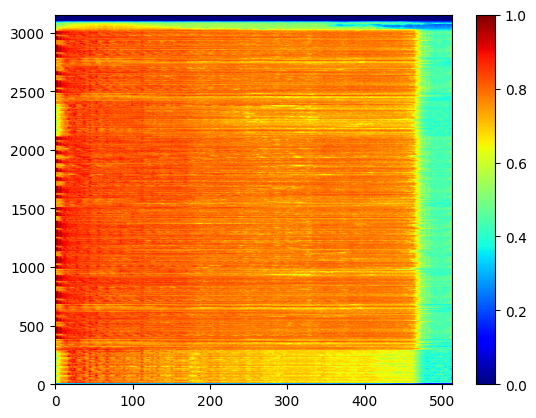

In [ ]:
import matplotlib.pyplot as plt

spectrogram = mp3_to_spectrogram('converted_songs/1.mp3')

plt.imshow(spectrogram, origin='lower', aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

Now we'll prepare the data

In [57]:
import os

def convert_audio_to_array(dir_path):
    # List of all files in the directory
    audio_files = [f for f in os.listdir(dir_path)]
    #List for all of the songs
    audio_data = []
    # Empty variable for the length of the longest song
    max_length = 0
    
    for audio_file in audio_files:
        # Read in song
        audio, sr = sf.read(os.path.join(dir_path, audio_file))
        # Append to list
        audio_data.append(audio)
        # Set max length variable
        max_length = max(max_length, audio.shape[0])
    
    # Create an empty array sized by the number of songs and the length of the longes
    audio_array = np.zeros((len(audio_data), max_length))
    
    for i, audio in enumerate(audio_data):
        # Create padding of zeros for all songs shorter than the longest song.
        # All of the songs need to be the same length for the next process
        padding = np.zeros((max_length - audio.shape[0],))
        # Finally create the array
        audio_array[i, :] = np.concatenate((audio, padding))
        
    return audio_array

In [59]:
audio_array = convert_audio_to_array('songs_converted')

In [62]:
# Select the columns to solve for
columns_for_model = ['danceability', 'energy','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence']
variables_array = df_files[columns_for_model].values
variables_array.shape

This is my first time using tensorflow. All of the following code was created by following tutorials online.

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the input shape
input_shape = (audio_array.shape[1],)

# Define the number of output classes
num_classes = variables_array.shape[1]

# Initialize the model
model = Sequential()

# Add the first dense layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu', input_shape=input_shape))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a second dense layer with 64 neurons and ReLU activation
model.add(Dense(64, activation='relu'))

# Add another dropout layer
model.add(Dropout(0.5))

# Add the final dense layer with num_classes neurons and sigmoid activation
model.add(Dense(num_classes, activation='sigmoid'))

# Compile the model with mean squared error loss and the Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Train the model using the audio_array and target_array as input and output
model.fit(audio_array, variables_array, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
3/3 [==============================] - 48s 8s/step - loss: 0.2438 - accuracy: 0.1000 - val_loss: 0.2941 - val_accuracy: 0.1000
Epoch 2/50
3/3 [==============================] - 14s 5s/step - loss: 0.3488 - accuracy: 0.3250 - val_loss: 0.2847 - val_accuracy: 0.1500
Epoch 3/50
3/3 [==============================] - 13s 4s/step - loss: 0.3572 - accuracy: 0.3000 - val_loss: 0.2781 - val_accuracy: 0.1500
Epoch 4/50
3/3 [==============================] - 13s 4s/step - loss: 0.3205 - accuracy: 0.3250 - val_loss: 0.2647 - val_accuracy: 0.1500
Epoch 5/50
3/3 [==============================] - 13s 4s/step - loss: 0.3300 - accuracy: 0.3500 - val_loss: 0.2542 - val_accuracy: 0.1500
Epoch 6/50
3/3 [==============================] - 13s 5s/step - loss: 0.2961 - accuracy: 0.3625 - val_loss: 0.2424 - val_accuracy: 0.1500
Epoch 7/50
3/3 [==============================] - 13s 4s/step - loss: 0.3090 - accuracy: 0.4125 - val_loss: 0.2369 - val_accuracy: 0.1000
Epoch 8/50
3/3 [==================

In [74]:
test_loss, test_accuracy = model.evaluate(audio_array, variables_array)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_accuracy)

4/4 [==============================] - 1s 189ms/step - loss: 0.1552 - accuracy: 0.3700
Test Loss:  0.15518121421337128
Test Accuracy:  0.3700000047683716


And as you can see, the model is not very accurate. Only 37%.<br>
I learned a lot about audio workflows with this project and plan on coming back to it when I have more knowledge on the subject to hopefully construct a better model.